## Pre-explanation:

1. In this notebook I used auto arima to predict and forecast the time series.

2. As some of the stores were closed for a few months or half year, therefore I compared the model performance by feeding them with different training data:

+ Method 1: Used the whole data set and drop the zero values to to do train test split 
+ Method 2: Separate the whole data to 2 parts with continuing zero value in between them, and use the second part to do train test split.

3. Compare R2 and MAE result from Method 1 and Method 2, choose the method with better performance to do the final forecasting

Please check the process for me and if it looks okay, in the final notebook I will write class and function to automate the whole comparing process and will add 95% confidence interval to the forecasting result.

In [121]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
%matplotlib inline

In [122]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone3/Data') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone3/Data
/Users/liuyang/Desktop/Springboard_Capstone3/Data


In [123]:
df = pd.read_csv('train.csv')

In [124]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [125]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [126]:
df = df.sort_values(['Date', 'Store'], ascending=True)

In [127]:
storeid=186
storedailydata=df.loc[df.Store==storeid]
storeweeklysales = storedailydata.set_index('Date').resample('w').Sales.sum()
print(f'The shape of storeweeklysales is: {storeweeklysales.shape}')

The shape of storeweeklysales is: (135,)


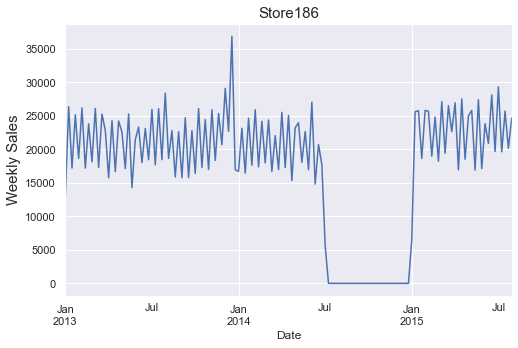

In [128]:
plt.rcParams['figure.figsize'] = (8, 5)
storeweeklysales.plot()
plt.title(f'Store{storeid}', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)
plt.show()

In [129]:
# check stationarity 
sta_result = adfuller(storeweeklysales)
print('ADF Statistic: %f' % sta_result[0])
print('p-value: %f' % sta_result[1])
print('Critical Values:')
for key, value in sta_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.713391
p-value: 0.424227
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578


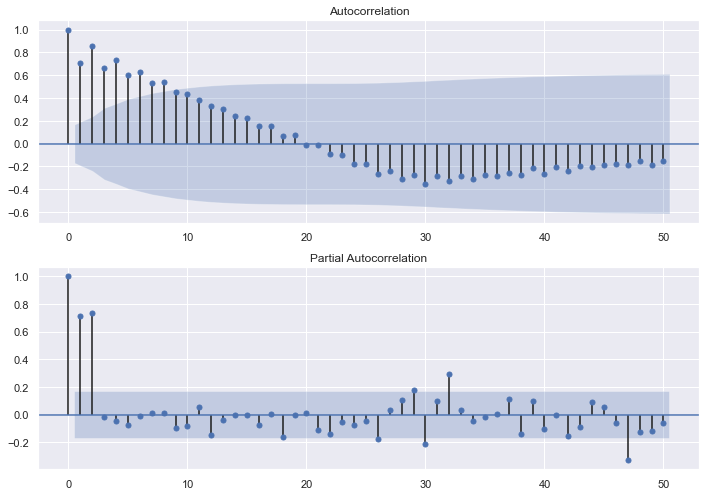

In [130]:
fig, ax = plt.subplots(2,1,figsize=(10,7))
plot_acf(storeweeklysales, lags=50, ax=ax[0])
# ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
# ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
#ax[0].legend()
plot_pacf(storeweeklysales, lags=50, ax=ax[1])
plt.tight_layout()

# Method 1: Use the whole data set to train model. 
1) When there's no zero value in the data set use the whole dataset to do train test split.

2) When there's zero value in the data set, drop it and use the non-zero value to do train test split. 

In [131]:
storeweeklysales = storeweeklysales[storeweeklysales!=0]

# when there's zero value, the data set will shrink, 
# when there's no zero value, data set will stay the same shape

In [132]:
# storeweeklysales.plot()
# plt.show()

In [133]:
train = storeweeklysales[:-9]
test = storeweeklysales[-9:-1]
print(f'The shape of storeweeklysales is {storeweeklysales.shape}')
print(f'Train set start from {train.index[0]} week,\nends at {train.index[-1]} week')
print(f'Test set start from {test.index[0]} week,\nends at {test.index[-1]} week')

The shape of storeweeklysales is (110,)
Train set start from 2013-01-06 00:00:00 week,
ends at 2015-05-31 00:00:00 week
Test set start from 2015-06-07 00:00:00 week,
ends at 2015-07-26 00:00:00 week


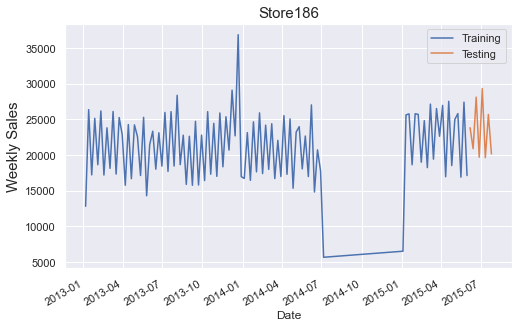

In [134]:
train.plot(label='Training')
test.plot(label='Testing')
plt.ylabel('Weekly Sales', fontsize=15)
plt.title(f'Store{storeid}',fontsize=15)
plt.legend()
plt.show()

In [135]:
warnings.filterwarnings("ignore")

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)

predictions = pd.DataFrame(arima_model.predict(n_periods=8), index=test.index)
#predictions_ci = arima_model.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)

print('R2 for SARIMA model: {0:.3f}'.format(R2))
print('MAE for SARIMA model: {0:.1f}'.format(mae))                         

R2 for SARIMA model: 0.441
MAE for SARIMA model: 2124.9


In [136]:
# create data index for forecasting value from week 2015-08-02 to week 2015-09-20
forecastindex = pd.date_range('2015-07-27', '2015-09-20', freq='W')
forecastindex

DatetimeIndex(['2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')

In [137]:
arima_model = auto_arima(storeweeklysales[:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)

# forecast = pd.DataFrame(forecast, index=forecastindex)


In [138]:
pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

,Forecast,lower CI,upper CI
2015-08-02,24457.885489,15053.213992,33862.556986
2015-08-09,21328.465140,11884.002242,30772.928039
2015-08-16,23671.829872,12955.498189,34388.161555
2015-08-23,21973.135194,11248.395902,32697.874486
2015-08-30,23266.716347,12115.470310,34417.962383
2015-09-06,22364.948771,11212.770965,33517.126577
2015-09-13,23069.322662,11754.434219,34384.211105
2015-09-20,22613.602270,11300.471787,33926.732754


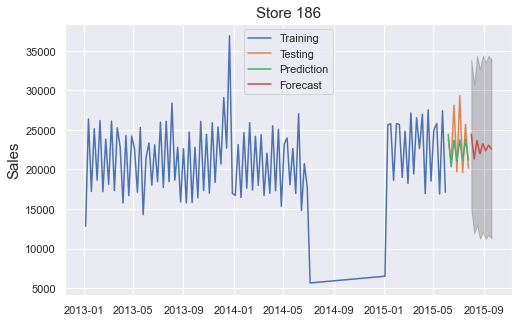

In [139]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

# Method 2: When there's continuing zero value in the data set, separate the data set to 2 parts with continuing zero value in between them, and use the second part to do train test split

In [140]:
storedailydata=df.loc[df.Store==storeid]
storeweeklysales = storedailydata.set_index('Date').resample('w').Sales.sum()

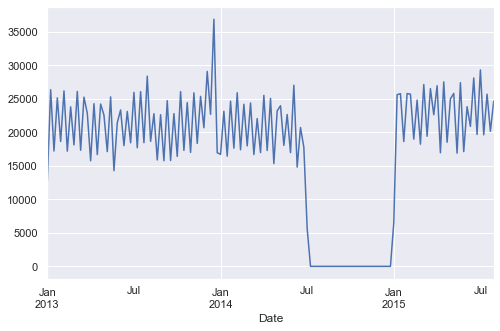

In [141]:
storeweeklysales.plot()

In [142]:
from sys import exit

# if there's zero weekly sales in the data set, 
# filter out the index(week date) of the last week that has zero sales, 
# and our training set should start from the week after it
if len(storeweeklysales[(storeweeklysales == 0)].index) != 0:
    train_startdate = storeweeklysales.loc[storeweeklysales[(storeweeklysales == 0)].index[-1]:].index[1]


else:
    print('There is no zero value in the data set')
    exit()

In [143]:
from sys import exit

if len(storeweeklysales.loc[train_startdate:]) >=11:
    train_enddate = len(storeweeklysales.loc[train_startdate:])-9
    train = storeweeklysales.loc[train_startdate:][:train_enddate]
    test = storeweeklysales.loc[train_startdate:][train_enddate:-1]
else:
    print('Test set does not have enough datas')
    exit()
# if the training set is too short to do 8 weeks prediction (and forecasting) 
# then we will go back to the first methd which is use the whole data set and drop the zero values

In [144]:
print(f'Train set start from week {train.index[0]},\nends at week {train.index[-1]}')
print(f'Test set start from week {test.index[0]},\nends at week {test.index[-1]}')

Train set start from week 2015-01-04 00:00:00,
ends at week 2015-05-31 00:00:00
Test set start from week 2015-06-07 00:00:00,
ends at week 2015-07-26 00:00:00


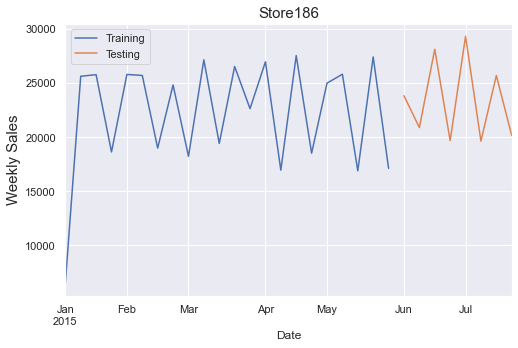

In [145]:
train.plot(label='Training')
test.plot(label='Testing')
plt.ylabel('Weekly Sales', fontsize=15)
plt.title(f'Store{storeid}',fontsize=15)
plt.legend()
plt.show()

In [146]:
forecastindex = pd.date_range('2015-07-27', '2015-09-20', freq='W')
forecastindex

DatetimeIndex(['2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')

In [147]:
warnings.filterwarnings("ignore")
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)

predictions = pd.DataFrame(arima_model.predict(n_periods=8), index=test.index)
#predictions_ci = arima_model.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
R2 = r2_score(true_values, predictions)

print('R2 for SARIMA model: {0:.3f}'.format(R2))
print('MAE for SARIMA model: {0:.1f}'.format(mae))                     

R2 for SARIMA model: 0.554
MAE for SARIMA model: 1832.4


In [148]:
arima_model = auto_arima(storeweeklysales.loc[train_startdate:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)
pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

,Forecast,lower CI,upper CI
2015-08-02,26193.321429,16024.521203,36362.121654
2015-08-09,20653.321429,10484.521203,30822.121654
2015-08-16,26683.642857,12302.787665,41064.498049
2015-08-23,21143.642857,6762.787665,35524.498049
2015-08-30,27173.964286,9561.085643,44786.842929
2015-09-06,21633.964286,4021.085643,39246.842929
2015-09-13,27664.285714,7326.685263,48001.886166
2015-09-20,22124.285714,1786.685263,42461.886166


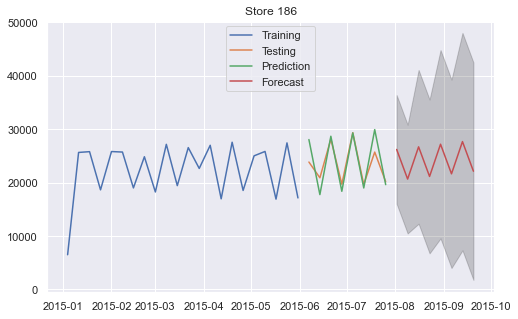

In [149]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(test,label="Test")
plt.plot(predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}')
plt.legend(loc = 'upper center')
plt.show()

Compare the metrics of method1 and method2, choose the one with the best result to be the final model to do forecasting for the future 7 weeks :
2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'

In the case of store 186, as method 2 generated better R2 and MAE than method 1, so we wil use method 2 to do forecasting

## Question:

1. After exploring these 2 methods with different store data, I realized some store's weekly sales data are white noise as there's no auto correlation found in their acf and pacf plot. (For example store 262) 
So my question is for white noise data, is calculating the average of the previous lags the best way to forecast the future value?

2. Shall I start adding exogenous variables to improve the model performance

In [150]:
class modeling:
    def __init__(self, data, storeid):
        self.data = data
        self.storeid = storeid
    
    def forecast(self, start_date, end_date):
        storeweeklysales = self.data.loc[self.data.Store==self.storeid].set_index('Date').resample('w').Sales.sum()
        #storeweeklysales = storeweeklysales[storeweeklysales!=0]
        forecastindex = pd.date_range(start_date, end_date, freq='W')
        if len(storeweeklysales[(storeweeklysales == 0)].index) == 0:
            train, test = (storeweeklysales[:-9], storeweeklysales[-9:-1])
            arima_model = auto_arima(storeweeklysales[:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


            forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)
            forecastresult1 = pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)
            return forecastresult1
        
        else:
            train_startdate = storeweeklysales.loc[storeweeklysales[(storeweeklysales == 0)].index[-1]:].index[1]
            if len(storeweeklysales.loc[train_startdate:]) >=11:
                train_enddate = len(storeweeklysales.loc[train_startdate:])-9
                train = storeweeklysales.loc[train_startdate:][:train_enddate]
                test = storeweeklysales.loc[train_startdate:][train_enddate:-1]
                
                arima_model = auto_arima(storeweeklysales.loc[train_startdate:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


                forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)
                return pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

                
            else:
                storeweeklysales = storeweeklysales[storeweeklysales!=0]
                train, test = (storeweeklysales[:-9], storeweeklysales[-9:-1])
                arima_model = auto_arima(storeweeklysales[:test.index[-1]],start_p=0, d=0, start_q=0, 
                              max_p=5, max_d=5, max_q=5, start_P=0, 
                              D=1, start_Q=0, max_P=5, max_D=5,
                              max_Q=5, m=2, seasonal=True, 
                              error_action='warn',trace = False,
                              supress_warnings=True,stepwise = False,
                              random=True,
                              random_state=20, n_fits=50)


                forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)
                forecastresult1 = pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)
                return forecastresult1


In [151]:
ndf = pd.read_csv('train.csv')
ndf = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [152]:
modeling(df, 186).forecast('2015-07-27', '2015-09-20')

,Forecast,lower CI,upper CI
2015-08-02,26193.321429,16024.521203,36362.121654
2015-08-09,20653.321429,10484.521203,30822.121654
2015-08-16,26683.642857,12302.787665,41064.498049
2015-08-23,21143.642857,6762.787665,35524.498049
2015-08-30,27173.964286,9561.085643,44786.842929
2015-09-06,21633.964286,4021.085643,39246.842929
2015-09-13,27664.285714,7326.685263,48001.886166
2015-09-20,22124.285714,1786.685263,42461.886166
